In [1]:
import zipfile

# Path to your zip file and target directory
zip_file_path = 'archive.zip'
extract_to = '/content/Soil-classification-dataset'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)


In [1]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths and parameters
dataset_path = '/content/Soil-classification-dataset/NASA_Soil_Moisture_India_Dataset/Soil_classification_dataset_preprocessed'
temp_dataset_path = '/content/Soil_classification_sampled'
image_size = (96, 96)  # Input size for MobileNetV2
batch_size = 32  # Adjusted batch size
validation_split = 0.2
samples_per_class = 5000  # Adjust the number of samples per class
num_classes = 3  # Number of classes (Ensure dataset is filtered to 3 classes)

# Ensure the temporary directory is clean before use
if os.path.exists(temp_dataset_path):
    shutil.rmtree(temp_dataset_path)
os.makedirs(temp_dataset_path)

# Limit the dataset to 3 classes and sample images
target_classes = ['Dry', 'Moderate_moisture', 'Highest_moisture']  # Ensure these match your dataset
for class_name in target_classes:
    class_dir = os.path.join(dataset_path, class_name)
    temp_class_dir = os.path.join(temp_dataset_path, class_name)
    os.makedirs(temp_class_dir, exist_ok=True)

    # Get all images and sample them
    images = os.listdir(class_dir)
    selected_images = random.sample(images, min(samples_per_class, len(images)))  # Sample up to the specified limit

    # Copy selected images to the temporary directory
    for img in selected_images:
        shutil.copy(os.path.join(class_dir, img), temp_class_dir)

print(f"Sampled dataset created at {temp_dataset_path}")

# Data Augmentation and Data Generators
datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values to [0, 1]
    validation_split=validation_split
)

# Load training and validation data (target size and batch size adjusted)
train_generator = datagen.flow_from_directory(
    temp_dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    temp_dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Define the MobileNetV2 model for classification with 3 classes
def mobilenet_model(input_shape=(96, 96, 3), num_classes=3):
    base_model = MobileNetV2(include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Dropout to prevent overfitting
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base model layers except for the last few
    for layer in base_model.layers[:-10]:
        layer.trainable = False

    # Compile the model with SGD optimizer
    model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
    #model.summary()




Sampled dataset created at /content/Soil_classification_sampled
Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [2]:
# Initialize and train the model
model = mobilenet_model(input_shape=(96, 96, 3), num_classes=num_classes)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=12,  # Increased to 15 epochs
    verbose=1
)

C:\Users\91810\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
375/375 ━━━━━━━━━━━━━━━━━━━━ 153s 392ms/step - accuracy: 0.8928 - loss: 0.2730 - val_accuracy: 0.7680 - val_loss: 0.8063
Epoch 2/12
375/375 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.9824 - loss: 0.0531 - val_accuracy: 0.8677 - val_loss: 0.2662
Epoch 3/12
375/375 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.9826 - loss: 0.0490 - val_accuracy: 0.9893 - val_loss: 0.0381
Epoch 4/12
375/375 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.9870 - loss: 0.0339 - val_accuracy: 0.9917 - val_loss: 0.0219
Epoch 5/12
375/375 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.9887 - loss: 0.0345 - val_accuracy: 0.9893 - val_loss: 0.0288
Epoch 6/12
375/375 ━━━━━━━━━━━━━━━━━━━━ 74s 197ms/step - accuracy: 0.9910 - loss: 0.0254 - val_accuracy: 0.9910 - val_loss: 0.0208
Epoch 7/12
375/375 ━━━━━━━━━━━━━━━━━━━━ 72s 193ms/step - accuracy: 0.9932 - loss: 0.0189 - val_accuracy: 0.9927 - val_loss: 0.0182
Epoch 8/12
375/375 ━━━━━━━━━━━━━━━━━━━━ 75s 200ms/step - accuracy: 0.9938 - loss: 

In [3]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.2f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 226ms/step - accuracy: 0.9936 - loss: 0.0194
Validation Accuracy: 99.37%
Validation Loss: 0.02


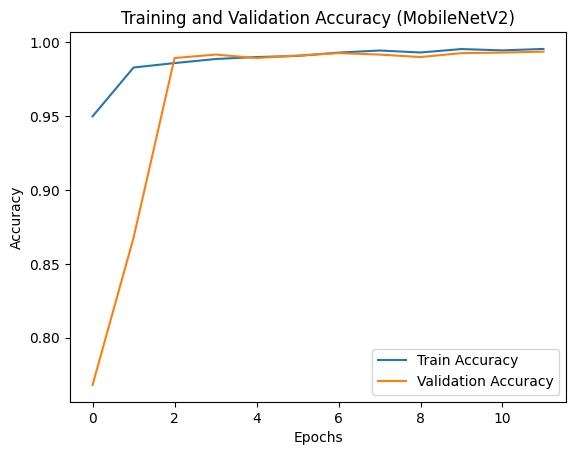

In [4]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (MobileNetV2)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

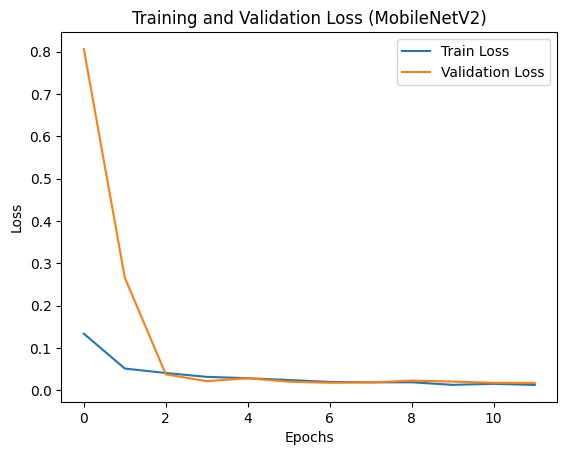

In [5]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (MobileNetV2)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 250ms/step
Class labels: {'Dry': 0, 'Moderate_moisture': 1, 'Highest_moisture': 2}


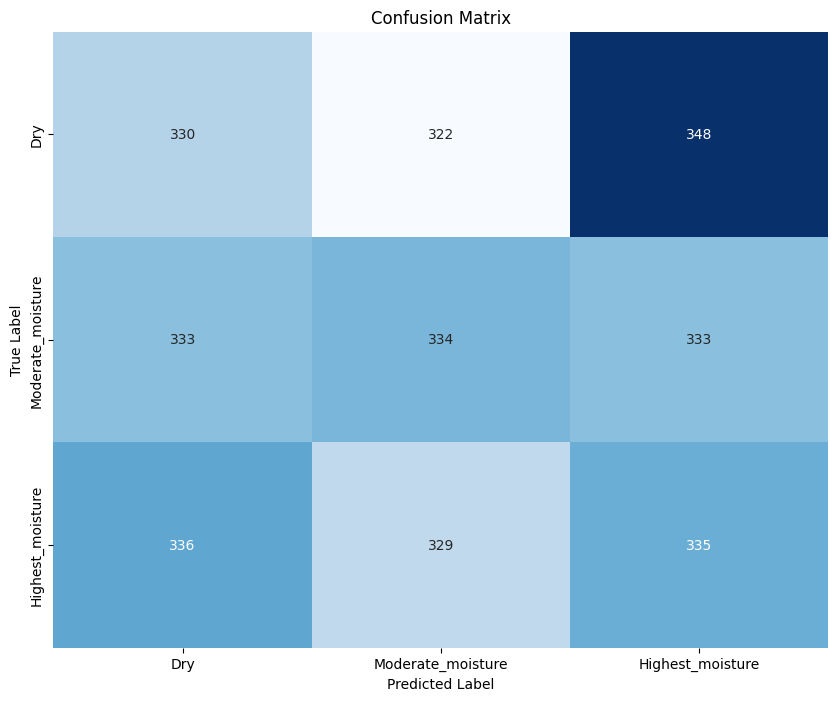

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Predict the classes on the validation data
y_true = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# 2. Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

#class_labels= {'Dry': 0, 'Moderate_dry': 1, 'Moderate_moisture': 2, 'Higher_moisture': 3, 'Highest_moisture': 4, 'Other': 5}
class_labels= {'Dry': 0, 'Moderate_moisture': 1, 'Highest_moisture': 2}
print("Class labels:", class_labels)

# 3. Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels.keys(), yticklabels=class_labels.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [7]:
from sklearn.metrics import classification_report

# 1. Predict the classes on the validation data
y_true = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# 2. Generate the classification report
report = classification_report(y_true, y_pred_classes, target_names=class_labels.keys())

# 3. Print the classification report
print("Classification Report:")
print(report)


94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 230ms/step
Classification Report:
                   precision    recall  f1-score   support

              Dry       0.33      0.33      0.33      1000
Moderate_moisture       0.35      0.34      0.34      1000
 Highest_moisture       0.32      0.33      0.32      1000

         accuracy                           0.33      3000
        macro avg       0.33      0.33      0.33      3000
     weighted avg       0.33      0.33      0.33      3000

